In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage.filters
import scipy.io as sio
import similaritymeasures

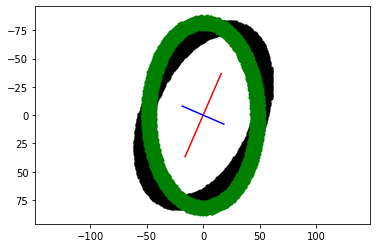

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage.filters


img = imageio.imread('../../Desktop/rangamani/oval.png')
y, x = np.nonzero(img)

x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])

cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

scale = 20
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.plot(x, y, 'k.')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
theta = np.tanh((x_v1)/(y_v1))  
#print(theta)
rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
transformed_mat = rotation_mat * coords
# plot the transformed blob
x_transformed, y_transformed = transformed_mat.A
plt.plot(x_transformed, y_transformed, 'g.')




In [3]:
def read_mat_file(path):
    mat_contents = sio.loadmat(path)
    return {'x_fit': mat_contents['fit'][:,0], 'y_fit': mat_contents['fit'][:, 1], 'x_outerfit': mat_contents['outerfit'][:, 0], 'y_outerfit': mat_contents['outerfit'][:, 1]}

def smooth(x, box_pts): #for correcting ragged edges; not in use right now
    box = np.ones(box_pts)/box_pts
    x_smooth = np.convolve(x, box, mode='same')
    return x_smooth

def make_graph(x_data, y_data):
    plt.plot(x_data, y_data)

def make_symmetric(x_fit_data, y_fit_data):
        
    new_x_fit_data = np.absolute(x_fit_data) #that way we can calculate average x coord

    x_fit_data_transformed = np.zeros(len(new_x_fit_data)) #initialize resulting arrays
    y_fit_data_transformed = np.zeros(len(y_fit_data))
    
    x_start = np.argmin(np.absolute(0 - new_x_fit_data)) #what index has the value closest to 0 (so we know if the shape is skewed left/right)
    dist_from_mid = abs(len(new_x_fit_data) // 2 - x_start) #how far x_start is away from the actual middle of the array (used to shift resulting graph)

    #since x_start will rarely be exactly at middle of array, below expression ensures against arrayindexoutofbounds.
    for i in range(x_start if x_start <= (len(x_fit_data_transformed) // 2) else len(x_fit_data_transformed) - x_start):
        #since we want resulting figure to be perfectly symmetrical, we start from the middle of the new array and every value to left and right are the same
        x_fit_data_transformed[len(x_fit_data_transformed) // 2 - i] = - (new_x_fit_data[x_start - i] + new_x_fit_data[x_start + i]) / 2
        x_fit_data_transformed[len(x_fit_data_transformed) // 2 + i] = (new_x_fit_data[x_start - i] + new_x_fit_data[x_start + i]) / 2

    for i in range(len(y_fit_data_transformed) // 2 + 1):
        y_fit_data_transformed[i] = (y_fit_data[i] + y_fit_data[-1 - i]) / 2
        y_fit_data_transformed[-1 - i] = (y_fit_data[i] + y_fit_data[-1 - i]) / 2        
    
    #after the above loops, there are some values we didn't take into account in the calculations, so we do them here
    #leftover_data = (new_x_fit_data[0:dist_from_mid + 1] + new_x_fit_data[len(new_x_fit_data) - dist_from_mid - 1:]) / 2
    
    #x_fit_data_transformed[0:dist_from_mid + 1] = - np.flip(leftover_data) #the first few data
    #x_fit_data_transformed[len(new_x_fit_data) - dist_from_mid - 1:] = leftover_data #the last few datapoints
    #NOTE: the resulting array is not PERFECTLY symmetrical; sometimes it can be off by one x value
    

    #x_fit_data_transformed, y_fit_data_transformed, locs = truncate_tails(x_fit_data_transformed, y_fit_data_transformed)
    return x_fit_data_transformed, y_fit_data_transformed

def truncate_tails(x, y):
    locs = np.where(x == 0)[0]
    y = np.delete(y, locs)
    x = x[x != 0]
    return x, y, locs

def rotate_figure(x, y):
    x -= np.mean(x)
    y -= np.mean(y)
    coords = np.vstack([x, y])

    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    scale = 20
    plt.plot([x_v1*-scale*2, x_v1*scale*2], [y_v1*-scale*2, y_v1*scale*2], color='red')
    plt.plot([x_v2*-scale, x_v2*scale], [y_v2*-scale, y_v2*scale], color='blue')
    #plt.plot(x, y, 'k.')
    plt.axis('equal')
    #plt.gca().invert_yaxis()  
    theta = np.tanh((x_v1)/(y_v1))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                          [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
    
    # plot the transformed blob
    x_transformed, y_transformed = transformed_mat.A
    return x_transformed, y_transformed

def compute_dfd(x1, y1, x2, y2):
    return similaritymeasures.frechet_dist((x1, y1), (x2, y2))
    
def should_rotate(x, y): 
    sym_x, sym_y = make_symmetric(x, y)
    sym_x, sym_y, locs = truncate_tails(sym_x, sym_y)
    dfd_1 = compute_dfd(np.delete(x, locs), np.delete(y, locs), sym_x, sym_y)
    
    rotated_x, rotated_y = rotate_figure(x, y)
    rotate_then_sym_x, rotate_then_sym_y = make_symmetric(rotated_x, rotated_y)
    
    #print(len(rotate_then_sym_x))
    #print(len(rotate_then_sym_y))
    a = np.delete(rotated_x, locs)
    b = np.delete(rotated_y, locs)

    c = np.delete(rotate_then_sym_x, locs)
    d = np.delete(rotate_then_sym_y, locs)

    dfd_2 = compute_dfd(a, b, c, d)
                   
    return (dfd_1 > dfd_2)

In [4]:
#data = read_mat_file('../emm/matfiles/184.mat')
#old_x = data['x_fit']
#old_y = data['y_fit']

#new_x, new_y = rotate_figure(old_x, old_y)
#result_x, result_y = make_symmetric(new_x, new_y)
#make_graph(result_x, result_y)

#data2 = read_mat_file('../emm/matfiles/1.mat')
#old_x2 = data2['x_fit']
#old_y2 = data2['y_fit']
#plt.figure(2)
#make_graph(old_x2, old_y2)
#results2_x, results2_y = make_symmetric(old_x2, old_y2)
#make_graph(results2_x, results2_y)


FUCK
FUCK


/opt/anaconda3/envs/emm/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


FUCK


/opt/anaconda3/envs/emm/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


FUCK
FUCK


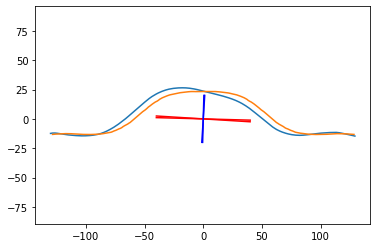

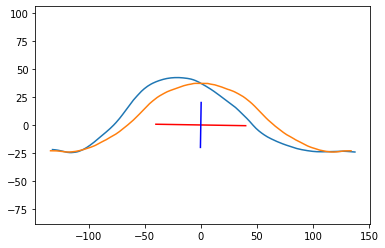

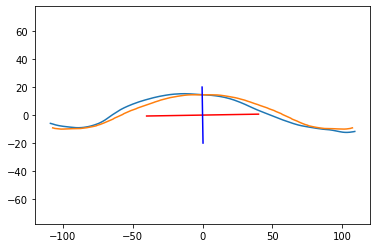

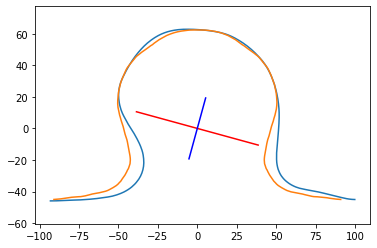

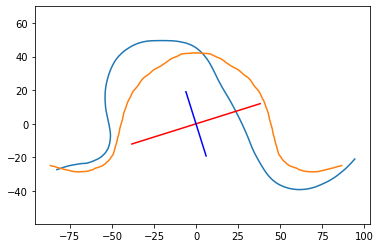

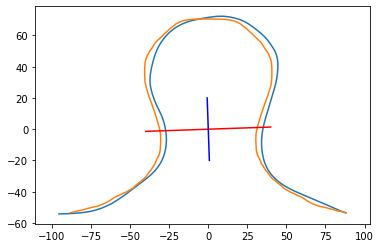

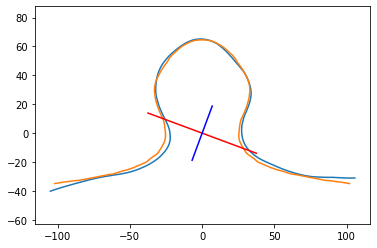

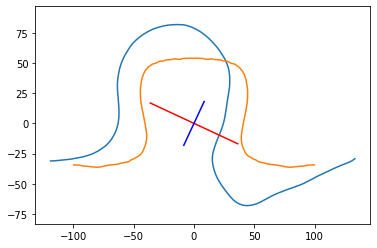

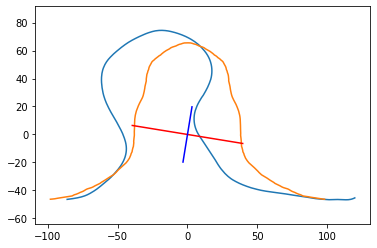

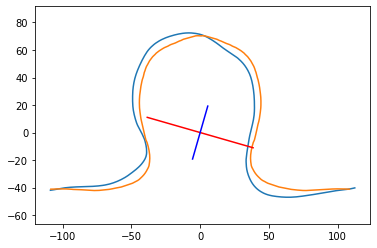

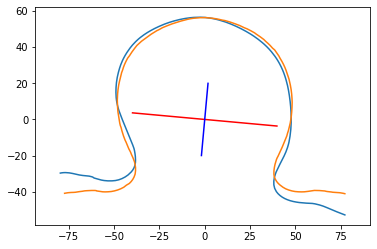

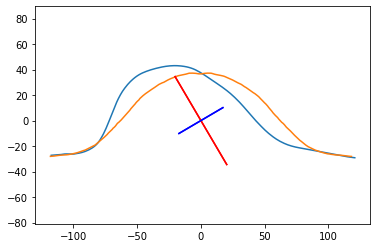

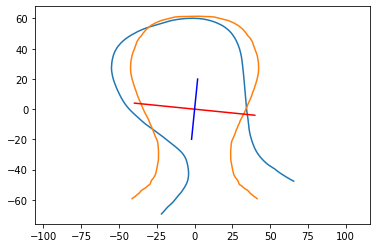

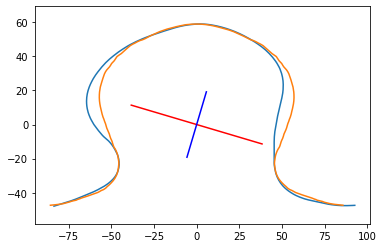

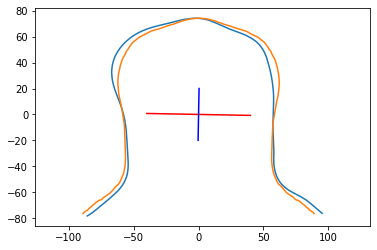

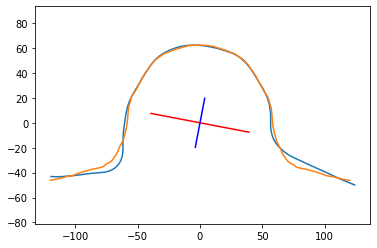

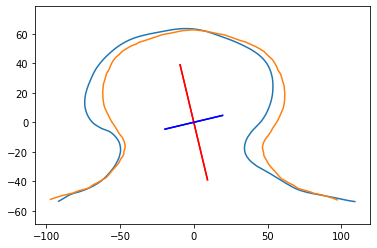

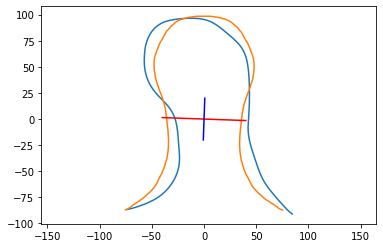

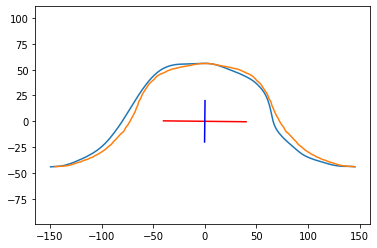

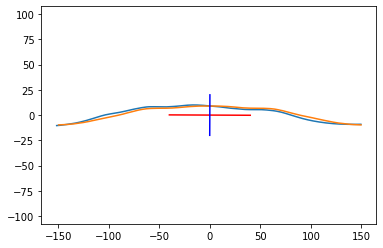

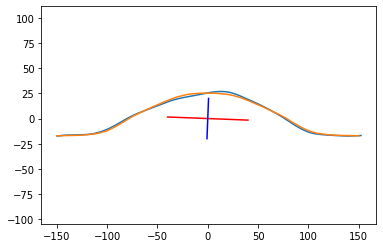

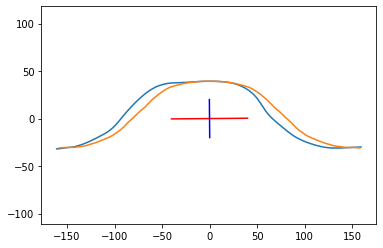

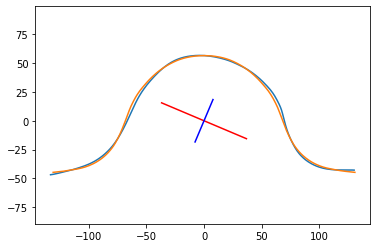

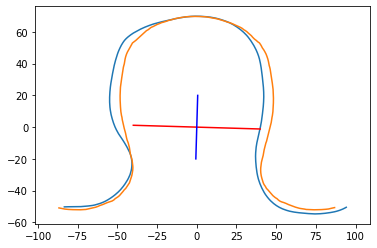

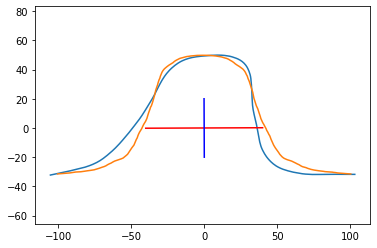

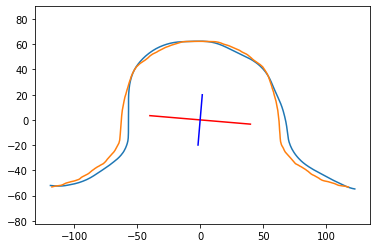

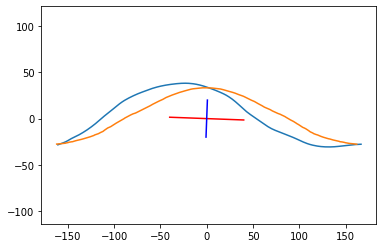

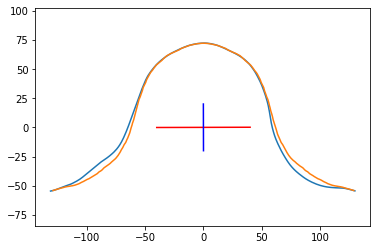

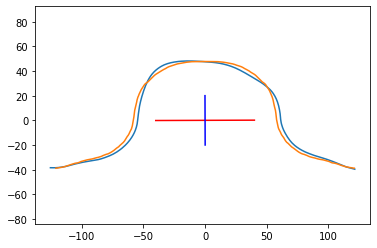

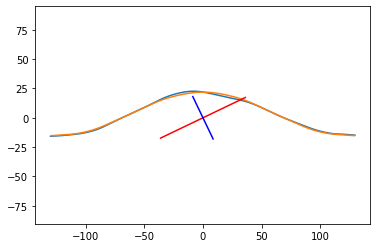

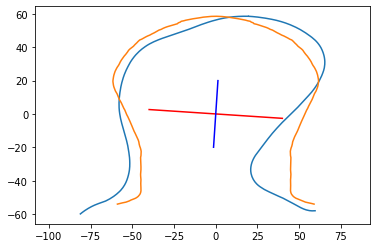

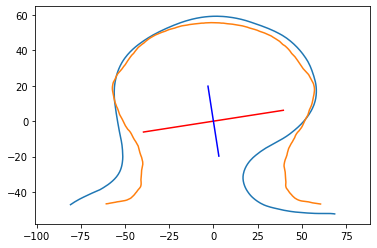

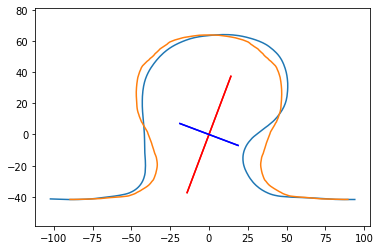

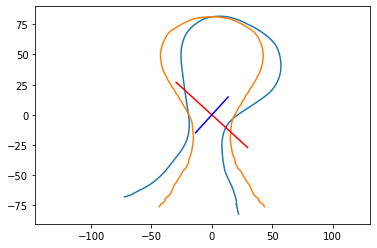

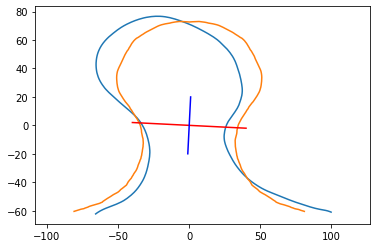

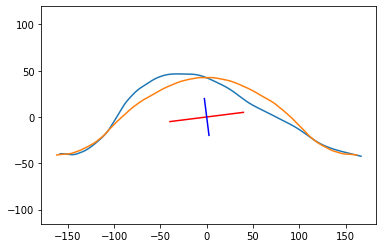

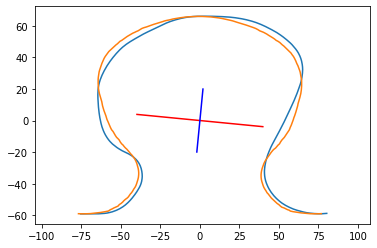

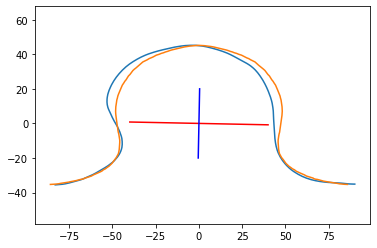

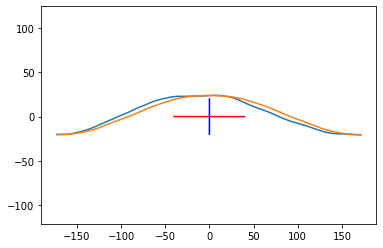

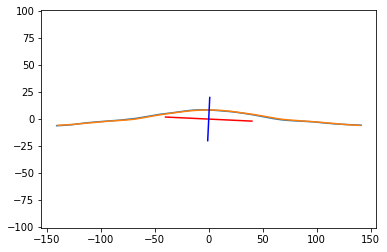

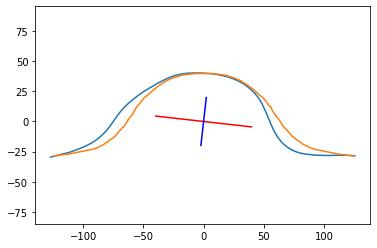

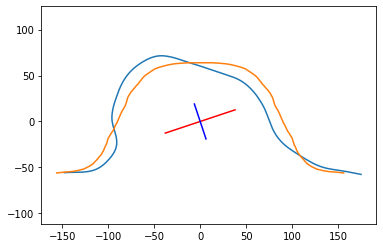

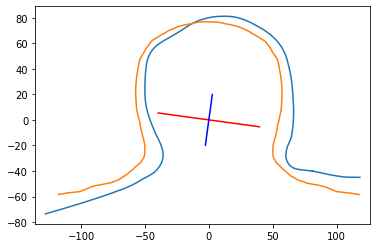

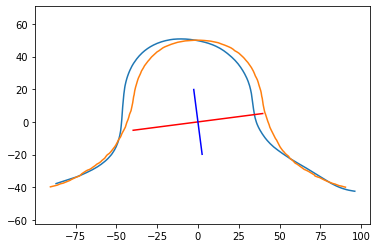

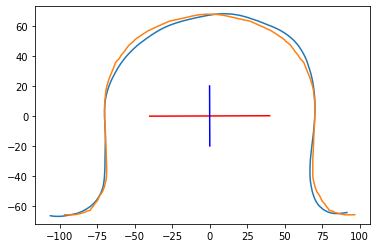

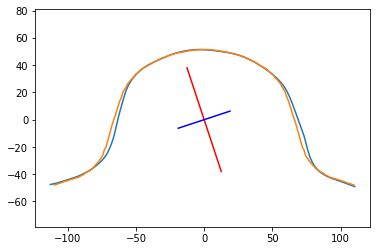

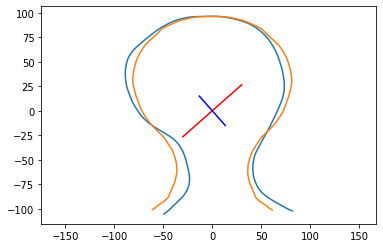

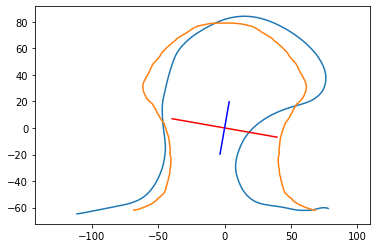

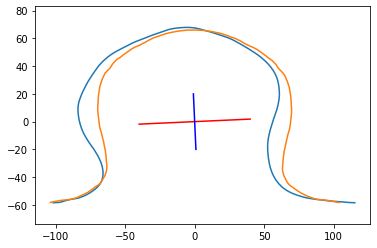

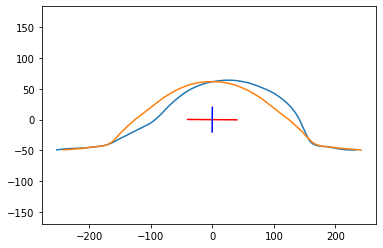

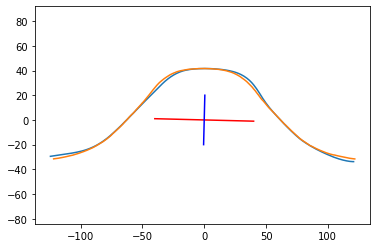

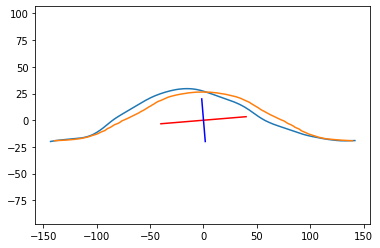

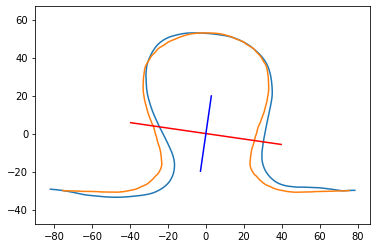

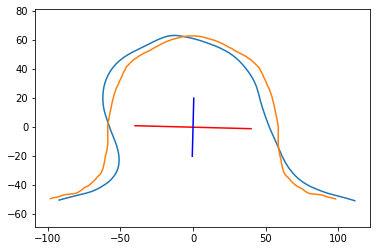

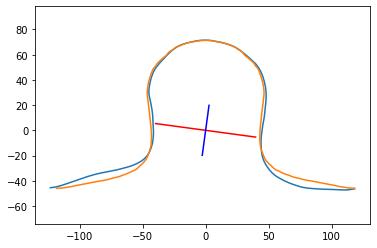

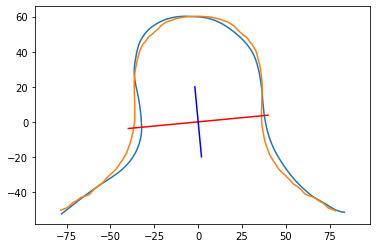

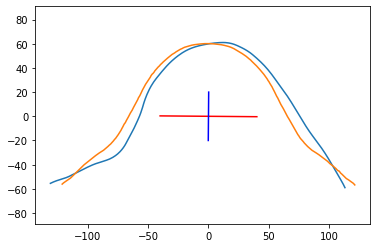

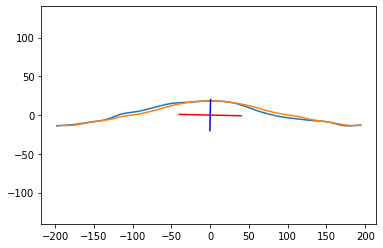

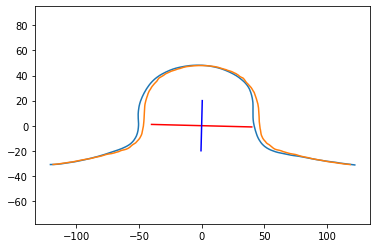

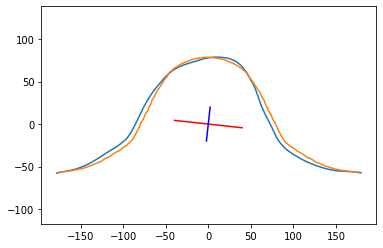

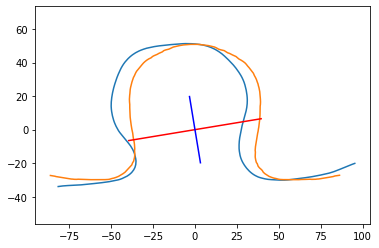

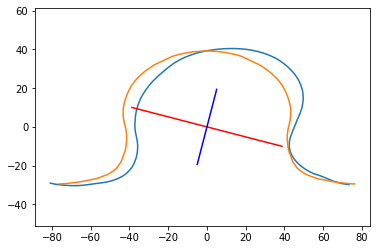

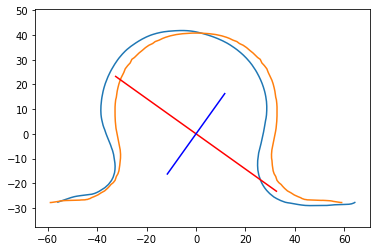

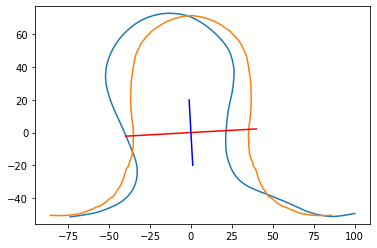

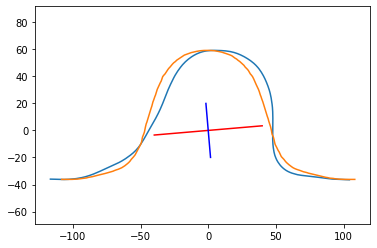

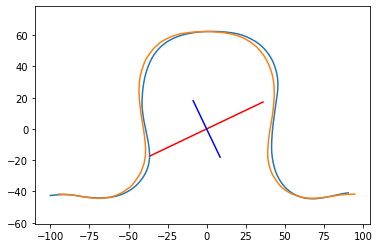

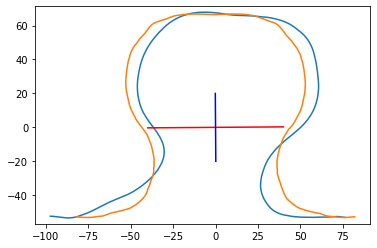

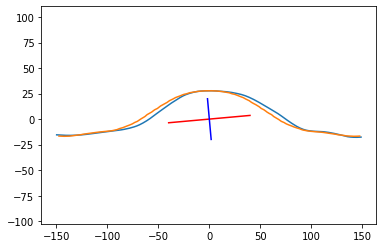

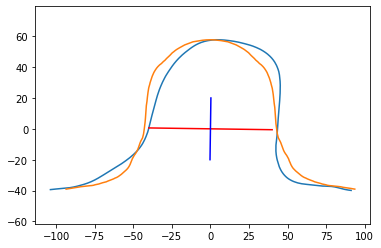

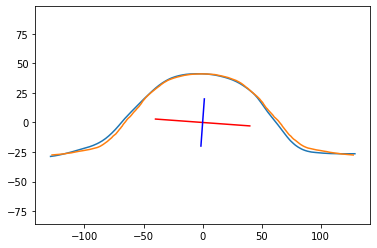

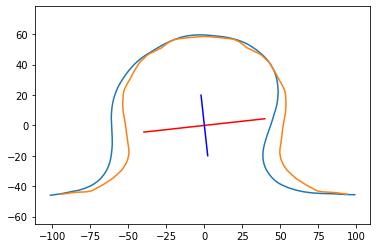

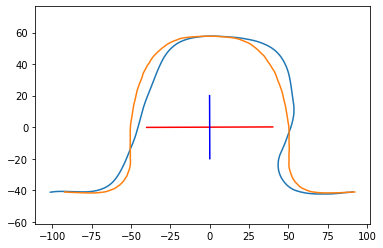

Error in callback <function flush_figures at 0x1173fcc20> (for post_execute):


KeyboardInterrupt: 

In [5]:
for i in range(100):
    data = read_mat_file('../emm/matfiles/' + str(i+1) + '.mat')
    old_x = data['x_fit']
    old_y = data['y_fit']

    if(should_rotate(old_x, old_y)):
        print("FUCK")
        new_x, new_y = rotate_figure(old_x, old_y)
        #plt.plot(new_x, new_y)
        sym_x, sym_y = make_symmetric(new_x, new_y)
        sym_x, sym_y, locs = truncate_tails(sym_x, sym_y)
        plt.figure(i)
        plt.plot(old_x, old_y)
        plt.plot(sym_x, sym_y)
    else:
        
        new_x2, new_y2 = make_symmetric(old_x, old_y)
        new_x2, new_y2, locs = truncate_tails(new_x2, new_y2)
        plt.figure(i)
        plt.plot(old_x, old_y)
        plt.plot(new_x2, new_y2)


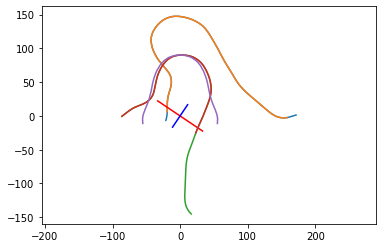

In [77]:
data = read_mat_file('../emm/matfiles/91.mat')
old_x = data['x_fit']
old_y = data['y_fit']

plt.axis('equal')
plt.plot(old_x, old_y)
x, y = make_symmetric(old_x, old_y)
x, y, locs = truncate_tails(x, y)

a = np.delete(old_x, locs)
b = np.delete(old_y, locs)
plt.plot(a, b)

a, b = rotate_figure(a, b)
plt.plot(a, b)

lol = np.where(b < -25)
b = b[b >= -25]
a = np.delete(a, lol)
plt.plot(a, b)

a, b = make_symmetric(a, b)
a, b, locs = truncate_tails(a, b)
plt.axis('equal')

plt.plot(a, b)

False

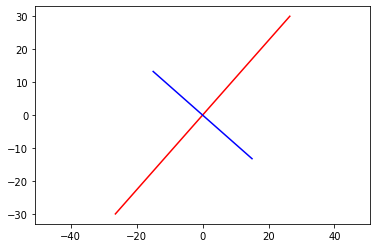

In [9]:
from scipy import integrate
data = read_mat_file('../emm/matfiles/91.mat')
old_x = data['x_outerfit']
old_y = data['y_outerfit']
#plt.plot(old_x, old_y)
should_rotate(old_x, old_y)

#new_x, new_y = rotate_figure(old_x, old_y)
#plt.plot(new_x, new_y)
#new_x, new_y, locs = make_symmetric(new_x, new_y)
#plt.plot(new_x, new_y)
#print(integrate.simps(new_y, new_x))